In [2]:
pip install google-play-scraper Sastrawi scikit-learn matplotlib wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.0 MB/s eta 0:00:00


In [3]:
from google_play_scraper import reviews
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud

import seaborn as sns
import re
import pandas as pd
import matplotlib.pyplot as plt
import pickle

app_id = 'id.go.bssn.bsre.tanaya'

result, _ = reviews(
    app_id,
    lang='id',
    country='id',
    count=1000,
    filter_score_with=None
)

df = pd.DataFrame(result)
df = df[['userName', 'score', 'content']]
df.columns = ['user', 'rating', 'review']
df.head()

,user,rating,review
0,TOOTALL SUPRIANDI,5,sangat membantu
1,DETA TV,3,"aplikasinya eror kah, kenapa tidak bsa login lagi"
2,herman arsip,5,bagus
3,Lutfi Awwali,1,"versi terbaru kemungkinan terdapat bug, saya t..."
4,Jalilludin al idrus,5,kenapa susah masuk .email nya padahal udah beb...


Jumlah data: 163
rating
5    84
1    32
3    17
2    17
4    13
Name: count, dtype: int64


<ipython-input-4-6e6dc156e3f3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


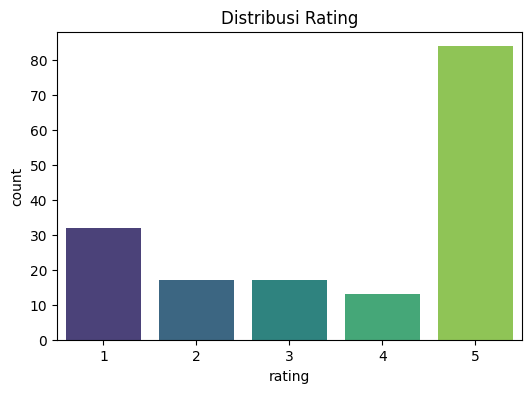

In [4]:
# EDA & visualisasi data awal
print("Jumlah data:", len(df))
print(df['rating'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribusi Rating')
plt.show()

In [5]:
# labeling sentimen
def label_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(label_sentiment)
df[['review', 'sentiment']].head(10)

,review,sentiment
0,sangat membantu,Positive
1,"aplikasinya eror kah, kenapa tidak bsa login lagi",Neutral
2,bagus,Positive
3,"versi terbaru kemungkinan terdapat bug, saya t...",Negative
4,kenapa susah masuk .email nya padahal udah beb...,Positive
5,ok,Positive
6,Kenapa aku susah banget login padahal username...,Positive
7,Kenapa aku susah banget login padahal username...,Positive
8,"Bagaimana reset google authenticatornya, tidak...",Positive
9,Bisa gak kl TTD nya dimunculkan dlm bentuk QR ...,Positive


In [6]:
# periksa jumlah data berdasarkan sentimen
print(df['sentiment'].value_counts())

sentiment
Positive    97
Negative    49
Neutral     17
Name: count, dtype: int64


In [7]:
# preprocessing
norm = {
    'bsa': 'bisa',
    'gk': 'tidak',
    'ga': 'tidak',
    'nggak': 'tidak',
    'ngak': 'tidak',
    'gak': 'tidak',
    'tdk': 'tidak',
    'udh': 'sudah',
    'udh': 'sudah',
    'sdh': 'sudah',
    'blm': 'belum',
    'aja': 'saja',
    'bgt': 'banget',
    'authentificator': 'authenticator',
    'ny': 'nya',
    'banget': 'sekali',
    'bener': 'benar',
    'dr': 'dari',
    'krn': 'karena',
    'tp': 'tapi',
    'kl': 'kalau',
    'klo': 'kalau',
    'dpt': 'dapat',
    'trus': 'terus',
    'trs': 'terus',
    'mf': 'maaf',
    'sbnrnya': 'sebenarnya',
    'daftar': 'registrasi',
    'regis': 'registrasi',
    'akun': 'account',
    'log': 'login',
    'pw': 'password',
    'otp': 'otp',
    'ota': 'otp',
    'hp': 'handphone',
    'emailnya': 'email',
    'akunny': 'akun',
    'gaada': 'tidak ada',
    'gaada': 'tidak ada',
    'ngetiknya': 'mengetik',
    'mohon': 'harap',
    'nya': '',
    'yg': 'yang',
    'mau': 'ingin',
    'mnt': 'menit',
    'mt': 'maintenance',
    'ttd': 'tanda tangan digital',
    'tandatangan': 'tanda tangan',
    'tte': 'tanda tangan elektronik',
    'mempermudah': 'memudahkan',
    'mwmbantu': 'membantu',
    'banget': 'sekali',
    'ok': 'baik',
    'oke': 'baik',
    'buat': 'membuat',
    'bnyak': 'banyak',
    'gitu': 'begitu',
    'mksdnya': 'maksudnya',
    'sblmnya': 'sebelumnya',
    'dtg': 'datang',
    'sgt': 'sangat',
    'punyq': 'punya',
    'sejenis': 'jenis',
    'khususnya': 'terutama',
    'blm': 'belum',
    'udah': 'sudah',
    'nyoba': 'mencoba',
    'maaf': 'mohon maaf',
    'min': 'admin',
    'app': 'aplikasi',
    'apl': 'aplikasi',
    'aplikasonya': 'aplikasinya',
    'aplikasinya': 'aplikasi',
    'diupdate': 'diperbarui',
    'lumayan': 'cukup',
    'bgs': 'bagus',
    'sekaligus': 'sekaligus',
    'dmn': 'dimana',
    'lbh': 'lebih',
    'jd': 'jadi',
    'smoga': 'semoga',
    'bgtu': 'begitu',
    'spt': 'seperti',
    'sya': 'saya',
    'sy': 'saya',
    'gausah': 'tidak usah',
    'malah': 'bahkan',
    'dlm': 'dalam',
    'mrk': 'mereka',
    'udh': 'sudah',
    'aja': 'saja',
    'smg': 'semoga',
    'gimana': 'bagaimana',
    'dan lain lain': '',
    'dll': '',
    'lah': '',
    'dong': '',
    'deh': '',
    'mah': '',
    'kok': '',
    'zz': '',
    'tok': 'saja',
    'punya': 'memiliki'
}

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)
stemmer = StemmerFactory().create_stemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split() # tokenisasi / text splitting
    corrected_words = [norm.get(word, word) for word in words] # mengganti typo dan singkatan dengan kata yang benar
    text = " ".join(corrected_words)

    text = stop_words_remover_new.remove(text) # penghapusan stopword
    text = stemmer.stem(text)  # stemming
    return text

df['review_clean'] = df['review'].astype(str).apply(preprocess)
df[['review_clean', 'sentiment']].head(5)

,review_clean,sentiment
0,sangat bantu,Positive
1,aplikasi eror kenapa bisa login,Neutral
2,bagus,Positive
3,versi baru mungkin dapat bug tidak guna tanda ...,Negative
4,susah masuk email padahal beberapa kali,Positive


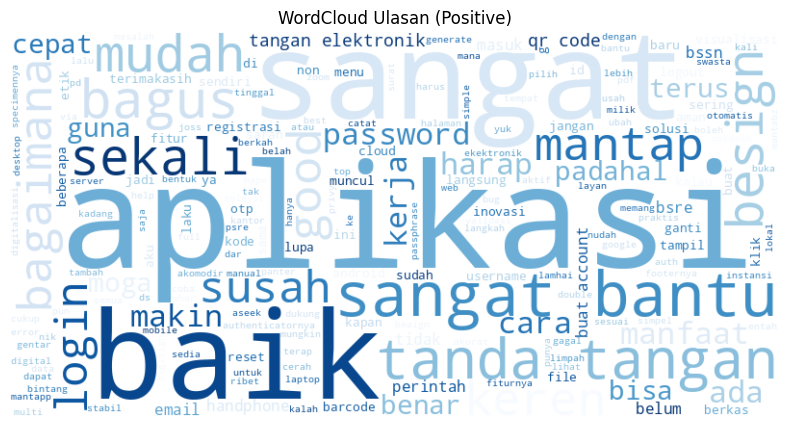

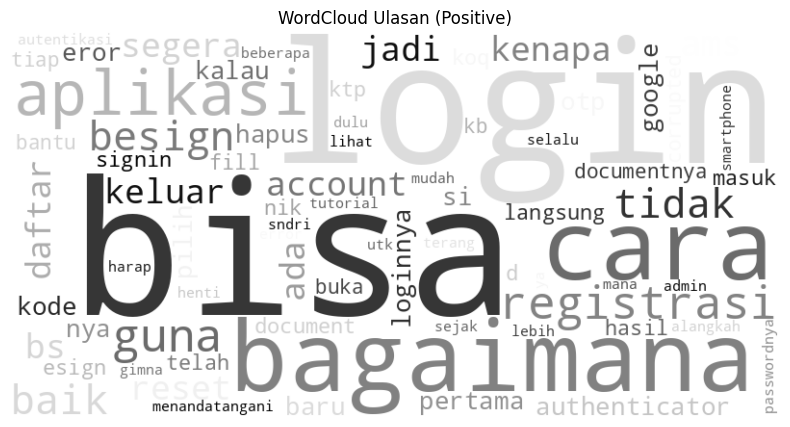

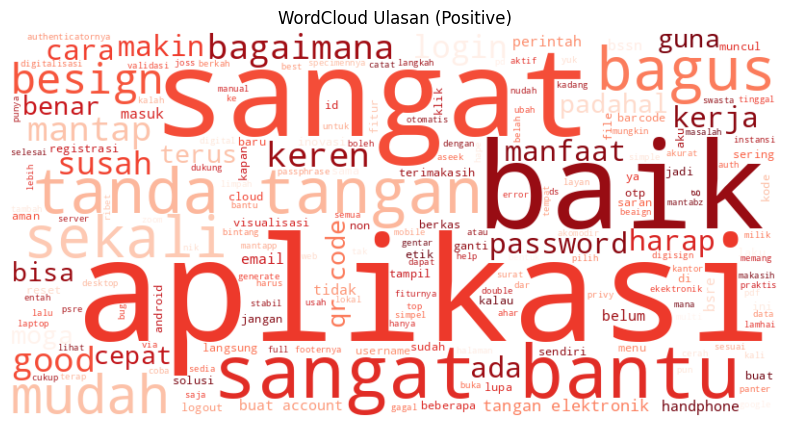

<ipython-input-19-76b0926c6547>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


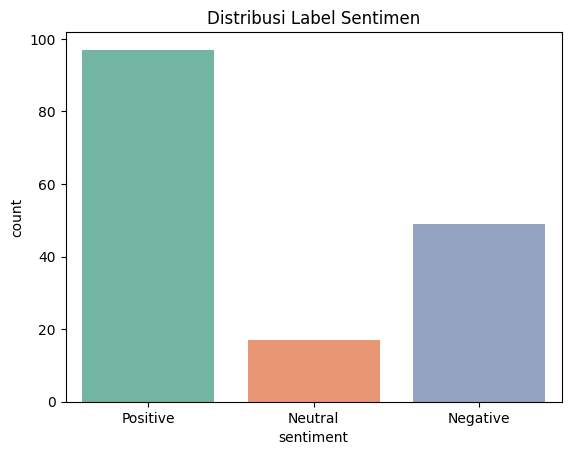

sentiment
Positive    0.595092
Negative    0.300613
Neutral     0.104294
Name: proportion, dtype: float64


In [19]:
# visualisasi wordcloud after normalisasi
data_negatif = df[df['sentiment'] == "Negative"]
data_neutral = df[df['sentiment'] == "Neutral"]
data_positif = df[df['sentiment'] == "Positive"]

all_clean_text = ' '.join(word for word in data_positif["review_clean"])
wordcloud = WordCloud(colormap='Blues', width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan (Positive)')
plt.show()

all_clean_text = ' '.join(word for word in data_neutral["review_clean"])
wordcloud = WordCloud(colormap='Greys', width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan (Positive)')
plt.show()

all_clean_text = ' '.join(word for word in data_positif["review_clean"])
wordcloud = WordCloud(colormap='Reds', width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan (Positive)')
plt.show()

sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Distribusi Label Sentimen')
plt.show()
print(df['sentiment'].value_counts(normalize=True))

In [9]:
# vektorisasi: TF-IDF
X = df['review_clean']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# melihat hasil TF-IDF dalam bentuk DataFrame
tfidf_df = pd.DataFrame(
    X_train_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# tampilkan beberapa baris pertama
print(tfidf_df.head())

    account      ada  admin  akhir  akomodir  aku  akun  alangkah  aman  ams  \
0  0.162286  0.13541    0.0    0.0  0.000000  0.0   0.0       0.0   0.0  0.0   
1  0.000000  0.00000    0.0    0.0  0.000000  0.0   0.0       0.0   0.0  0.0   
2  0.000000  0.00000    0.0    0.0  0.146419  0.0   0.0       0.0   0.0  0.0   
3  0.000000  0.00000    0.0    0.0  0.000000  0.0   0.0       0.0   0.0  0.0   
4  0.000000  0.00000    0.0    0.0  0.000000  0.0   0.0       0.0   0.0  0.0   

   ...     versi  visualisasi  vivo  wajar  walopun  website  websitenya   ya  \
0  ...  0.000000     0.000000   0.0    0.0      0.0      0.0         0.0  0.0   
1  ...  0.000000     0.000000   0.0    0.0      0.0      0.0         0.0  0.0   
2  ...  0.000000     0.134962   0.0    0.0      0.0      0.0         0.0  0.0   
3  ...  0.000000     0.000000   0.0    0.0      0.0      0.0         0.0  0.0   
4  ...  0.348658     0.195205   0.0    0.0      0.0      0.0         0.0  0.0   

   yuk      zoom  
0  0.0  0.000

In [17]:
# training model naive bayes
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

print("Classes:", clf.classes_)
print("Class Log Prior:", clf.class_log_prior_)
print("Feature Log Prob (first 5 features):", clf.feature_log_prob_[:, :5])

Classes: ['Negative' 'Neutral' 'Positive']
Class Log Prior: [-1.10633433 -2.22847712 -0.57707501]
Feature Log Prob (first 5 features): [[-5.35663274 -5.0248241  -6.20294224 -5.96843716 -6.20294224]
 [-5.5641345  -5.62975814 -5.62041748 -6.01866302 -6.01866302]
 [-5.66930257 -5.62326424 -6.25885903 -6.25885903 -6.12221622]]


In [11]:
# evaluasi model
y_pred = clf.predict(X_test_tfidf)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"\nAkurasi: {accuracy_score(y_test, y_pred)*100:.2f}%")


=== Classification Report ===
              precision    recall  f1-score   support

    Negative       0.29      0.33      0.31         6
     Neutral       0.00      0.00      0.00         3
    Positive       0.81      0.88      0.84        24

    accuracy                           0.70        33
   macro avg       0.36      0.40      0.38        33
weighted avg       0.64      0.70      0.67        33


Akurasi: 69.70%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# uji sample prediksi
sample_test = pd.DataFrame({'review_clean': X_test, 'true_label': y_test, 'pred_label': y_pred})
print("sample hasil prediksi:\n", sample_test.sample(10))

sample hasil prediksi:
                                           review_clean true_label pred_label
15                                                baik   Positive   Positive
51                               ada tombol registrasi   Negative   Negative
85   masalah ada barcode surat barcode tampil padah...   Positive   Positive
159                                         maju terus   Positive   Positive
66                                               bagus   Positive   Positive
9    tidak kalau tanda tangan digital muncul bentuk...   Positive   Positive
101                                              keren   Positive   Positive
24                                        praktis aman   Positive   Positive
132  account jadi bisa guna sejak autentikasi aplik...    Neutral   Positive
16           masuk beberapa account email bilang salah   Negative   Positive


In [13]:
# function prediksi dengan input text
def predict_review(text):
    # preprocessing
    tokens = preprocess(text)
    # Transform ke vektor TF-IDF
    vec = vectorizer.transform([tokens])
    # Prediksi sentimen
    pred = clf.predict(vec)
    return pred[0]

In [14]:
test_input = [
    "aplikasinya mantap dan sangat bermanfaat",
    "not recommended"
]
for review in test_input:
    print(f"Review: {review}")
    print(f"Prediksi: {predict_review(review)}\n")

Review: aplikasinya mantap dan sangat bermanfaat
Prediksi: Positive

Review: not recommended
Prediksi: Negative



In [15]:
# export model
# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# save vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)